In [1]:
# Parameters
kms_key = "arn:aws:kms:us-west-2:000000000000:1234abcd-12ab-34cd-56ef-1234567890ab"


# Run a SageMaker Experiment with MNIST Handwritten Digits Classification

This demo shows how you can use the [SageMaker Experiments Python SDK](https://sagemaker-experiments.readthedocs.io/en/latest/) to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyperparameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs are automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before or after model training, such as data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best-performing models.

We demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment is organized as follows:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyperparameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using the SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of the SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We also show an example of tracing the complete lineage of a model version: the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you select the `Python 3 (Data Science)` kernel in Studio, or `conda_pytorch_p36` in a notebook instance.

## Runtime

This notebook takes approximately 25 minutes to run.

## Contents

1. [Install modules](#Install-modules)
1. [Setup](#Setup)
1. [Download the dataset](#Download-the-dataset)
1. [Step 1: Set up the Experiment](#Step-1:-Set-up-the-Experiment)
1. [Step 2: Track Experiment](#Step-2:-Track-Experiment)
1. [Deploy an endpoint for the best training job / trial component](#Deploy-an-endpoint-for-the-best-training-job-/-trial-component)
1. [Cleanup](#Cleanup)
1. [Contact](#Contact)

## Install modules

In [2]:
import sys

### Install the SageMaker Experiments Python SDK

In [3]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.35

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


     |████████████████████████████████| 42 kB 1.3 MB/s 


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


### Install PyTorch

In [4]:
# PyTorch version needs to be the same in both the notebook instance and the training job container
# https://github.com/pytorch/pytorch/issues/25214
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.2.2
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


     |                                | 522 kB 5.7 MB/s eta 0:01:59

     |▏                               | 4.0 MB 5.7 MB/s eta 0:01:59

     |▍                               | 8.4 MB 5.7 MB/s eta 0:01:58

     |▋                               | 12.7 MB 5.7 MB/s eta 0:01:57

     |▊                               | 14.1 MB 5.7 MB/s eta 0:01:57

     |▊                               | 15.9 MB 5.7 MB/s eta 0:01:56

     |▉                               | 18.0 MB 5.7 MB/s eta 0:01:56

     |█                               | 20.7 MB 5.7 MB/s eta 0:01:56

     |█                               | 22.8 MB 5.7 MB/s eta 0:01:55

     |█▏                              | 24.3 MB 5.7 MB/s eta 0:01:55

     |█▎                              | 26.0 MB 5.7 MB/s eta 0:01:55

     |█▍                              | 28.6 MB 5.7 MB/s eta 0:01:54

     |█▍                              | 30.3 MB 5.7 MB/s eta 0:01:54

     |█▌                              | 32.1 MB 86.0 MB/s eta 0:00:08

     |█▋                              | 34.2 MB 86.0 MB/s eta 0:00:08

     |█▊                              | 36.3 MB 86.0 MB/s eta 0:00:08

     |█▊                              | 36.7 MB 86.0 MB/s eta 0:00:08

     |█▉                              | 38.0 MB 86.0 MB/s eta 0:00:08

     |██                              | 40.0 MB 86.0 MB/s eta 0:00:08

     |██                              | 42.2 MB 86.0 MB/s eta 0:00:08

     |██▏                             | 44.7 MB 86.0 MB/s eta 0:00:08

     |██▎                             | 47.4 MB 86.0 MB/s eta 0:00:08

     |██▌                             | 52.4 MB 101.3 MB/s eta 0:00:07

     |██▋                             | 54.5 MB 101.3 MB/s eta 0:00:07

     |██▋                             | 56.4 MB 101.3 MB/s eta 0:00:07

     |██▉                             | 59.1 MB 101.3 MB/s eta 0:00:07

     |██▉                             | 60.8 MB 101.3 MB/s eta 0:00:07

     |███                             | 61.5 MB 101.3 MB/s eta 0:00:07

     |███                             | 63.0 MB 101.3 MB/s eta 0:00:07

     |███                             | 64.7 MB 101.3 MB/s eta 0:00:07

     |███                             | 65.7 MB 101.3 MB/s eta 0:00:07

     |███▏                            | 67.7 MB 101.3 MB/s eta 0:00:07

     |███▎                            | 70.3 MB 147.3 MB/s eta 0:00:05

     |███▍                            | 72.3 MB 147.3 MB/s eta 0:00:05

     |███▌                            | 74.5 MB 147.3 MB/s eta 0:00:05

     |███▋                            | 76.7 MB 147.3 MB/s eta 0:00:05

     |███▊                            | 78.2 MB 147.3 MB/s eta 0:00:05

     |███▉                            | 80.1 MB 147.3 MB/s eta 0:00:05

     |████                            | 82.4 MB 147.3 MB/s eta 0:00:05

     |████                            | 84.5 MB 147.3 MB/s eta 0:00:05

     |████                            | 86.5 MB 147.3 MB/s eta 0:00:05

     |████▏                           | 88.2 MB 147.3 MB/s eta 0:00:04

     |████▎                           | 89.4 MB 1.3 MB/s eta 0:07:36

     |████▍                           | 92.1 MB 1.3 MB/s eta 0:07:34

     |████▍                           | 93.8 MB 1.3 MB/s eta 0:07:33

     |████▌                           | 95.6 MB 1.3 MB/s eta 0:07:32

     |████▋                           | 98.4 MB 1.

     |████▊                           | 99.9 MB 1.3 MB/s eta 0:07:28

     |████▉                           | 102.3 MB 1.3 MB/s eta 0:07:26

     |█████                           | 104.3 MB 1.3 MB/s eta 0:07:25

     |█████                           | 106.5 MB 1.3 MB/s eta 0:07:23

     |█████▏                          | 108.9 MB 1.3 MB/s eta 0:07:21

     |█████▏                          | 110.0 MB 1.3 MB/s eta 0:07:12

     |█████▎                          | 111.1 MB 1.3 MB/s eta 0:07:11

     |█████▍                          | 112.8 MB 1.3 MB/s eta 0:07:09

     |█████▍                          | 115.0 MB 1.3 MB/s eta 0:07:08

     |█████▌                          | 115.4 MB 1.3 MB/s eta 0:07:08

     |█████▌                 

     |█████▋                          | 118.5 MB 1.3 MB/s eta 0:07:05

     |█████▊                          | 120.1 MB 1.3 MB/s eta 0:07:04

     |█████▊                 

     |█████▉                          | 123.2 MB 1.3 MB/s eta 0:07:02

     |██████                          | 125.4 MB 1.3 MB/s eta 0:07:00

     |██████                

     |██████                          | 129.1 MB 72.4 MB/s eta 0:00:08

     |██████▏                         | 130.8 MB 72.4 MB/s eta 0:00:08

     |██████▎                         | 132.5 MB 72.4 MB/s eta 0:00:08

     |██████▍                         | 134.9 MB 72.4 MB/s eta 0:00:08

     |██████▌                         | 136.9 MB 72.4 MB/s eta 0:00:08

     |██████▌                         | 137.1 

     |██████▌                         | 137.8 MB 72.4 MB/s eta

     |██████▋                         | 139.2 MB 126 kB/s eta 1:10:53

     |██████▋                         | 140.0 MB 126 kB/s eta 1:10:46

     |██████▊                         | 141.3 MB 126 kB/s eta 1:10:37

     |██████▊                         | 143.0 MB 126 kB/s eta 1:10:23

     |██████▉                         | 145.3 MB 126 kB/s eta 1:10:04

     |███████                         | 147.5 MB 126 kB/s eta 1:09:47

     |███████                         | 149.3 MB 126 kB/s eta 1:09:33

     |███████▏                        | 151.2 MB 126 kB/s eta 1:09:18

     |███████▎                        | 153.8 MB 126 kB/s eta 1:08:57

     |███████▍                        | 156.3 MB 126 kB/s eta 1:08:37

     |███████▌                        | 158.3 MB 126 kB/s eta 1:08:22

     |███████▋                        | 160.5 MB 76.8 MB/s eta 0:00:07

     |███████▋                        | 161.9 MB 76.8 MB/s eta 0:00:07

     |███████▊                        | 164.3 MB 76.8 MB/s eta 0:00:07

     |███████▉                        | 166.8 MB 76.8 MB/s eta 0:00:07

     |████████                        | 167.5 MB 76.8 MB/s eta 0:00:07

     |████████                        | 168.6 MB 76.8 MB/s eta 0:00:07

     |████████                        | 170.7 MB 76.8 MB/s eta 0:00:07

     |████████▏                       | 173.3 MB 76.8 MB/s eta 0:00:07

     |████████▎                       | 175.4 MB 76.8 MB/s eta 0:00:07

     |████████▍                       | 177.9 MB 76.8 MB/s eta 0:00:07

     |████████▌                       | 180.4 MB 30.0 MB/s eta 0:00:17

     |████████▋                       | 182.1 MB 30.0 MB/s eta 0:00:17

     |████████▊                       | 183.7 MB 30.0 MB/s eta 0:00:17

     |████████▊                       | 185.2 MB 30.0 MB/s eta 0:00:17

     |████████▉                       | 187.5 MB 30.0 MB/s eta 0:00:17

     |█████████                       | 189.4 MB 30.0 MB/s eta 0:00:17

     |█████████                       | 191.4 MB 30.0 MB/s eta 0:00:17

     |█████████▏                      | 192.9 MB 30.0 MB/s eta 0:00:17

     |█████████▎                      | 195.3 MB 30.0 MB/s eta 0:00:17

     |█████████▎                      | 197.1 MB 30.0 MB/s eta 0:00:16

     |█████████▍                      | 198.9 MB 83.7 MB/s eta 0:00:06

     |█████████▌                      | 200.4 MB 83.7 MB/s eta 0:00:06

     |█████████▌                      | 200.9 MB 83.7 MB/s eta 0:00:06

     |█████████▌                      | 201.9 MB 83.7 MB/s eta 0:00:06

     |█████████▋            

     |█████████▊                      | 204.6 MB 83.7 MB/s eta 0:00:06

     |█████████▊                      | 206.6 MB 83.7 MB/s eta 0:00:06

     |█████████▉                      | 208.9 MB 83.7 MB/s eta 0:00:06

     |██████████                      | 210.4 MB 83.7 MB/s eta 0:00:06

     |██████████                      | 212.5 MB 83.7 MB/s eta 0:00:06

     |██████████▏                     | 214.4 MB 83.7 MB/s eta 0:00:06

     |██████████▏                     | 216.2 MB 83.7 

     |██████████▎                     | 217.9 MB 71.1 MB/s eta 0:00:07

     |██████████▍                     | 219.6 MB 71.1 MB/s eta 0:00:07

     |██████████▌                     | 222.0 MB 71.1 MB/s eta 0:00:07

     |██████████▋                     | 223.6 MB 71.1 MB/s eta 0:00:07

     |██████████▋                     | 225.3 MB 71.1 MB/s eta 0:00:07

     |██████████▊                     | 227.5 MB 71.1 MB/s eta 0:00:07

     |██████████▉                     | 229.5 MB 71.1 MB/s eta 0:00:07

     |███████████                     | 231.4 MB 71.1 MB/s eta 0:00:07

     |███████████                     | 232.8 MB 71.1 MB/s eta 0:00:07

     |███████████                     | 234.6 MB 79.2 MB/s eta 0:00:06

     |███████████▏                    | 236.6 MB 79.2 MB/s eta 0:00:06

     |███████████▎                    | 238.7 MB 79.2 MB/s eta 0:00:06

     |███████████▍                    | 240.8 MB 79.2 MB/s eta 0:00:06

     |███████████▌                    | 242.9 MB 79.2 MB/s eta 0:00:06

     |███████████▋                    | 245.7 MB 79.2 MB/s eta 0:00:06

     |███████████▊                    | 247.6 MB 79.2 MB/s eta 0:00:06

     |███████████▉                    | 249.5 MB 79.2 MB/s eta 0:00:06

     |████████████                    | 251.5 MB 79.2 MB/s eta 0:00:06

     |████████████                    | 253.3 MB 72.0 MB/s eta 0:00:06

     |████████████                    | 255.5 MB 72.0 MB/s eta 0:00:06

     |████████████▏                   | 257.5 MB 72.0 MB/s eta 0:00:06

     |████████████▎                   | 258.9 MB 72.0 MB/s eta 0:00:06

     |████████████▎                   | 260.8 MB 72.0 MB/s eta 0:00:06

     |████████████▍                   | 262.5 MB 72.0 MB/s eta 0:00:06

     |████████████▌                   | 264.6 MB 72.0 MB/s eta 0:00:06

     |████████████▋                   | 266.3 MB 72.0 MB/s eta 0:00:06

     |████████████▊                   | 268.2 MB 72.0 MB/s eta 0:00:06

     |████████████▉                   | 270.4 MB 72.0 MB/s eta 0:00:06

     |████████████▉                   | 270.8 MB 72.0 MB/s eta 0:00:06

     |█████████████                   | 273.8 MB 108.8 MB/s eta 0:00:04

     |█████████████                   | 275.2 MB 108.8 MB/s eta 0:00:04

     |█████████████▏                  | 277.7 MB 108.8 MB/s eta 0:00:04

     |█████████████▎                  | 280.0 MB 108.8 MB/s eta 0:00:04

     |█████████████▍                  | 282.1 MB 108.8 MB/s eta 0:00:04

     |█████████████▌                  | 284.4 MB 108.8 MB/s eta 0:00:04

     |█████████████▋                  | 286.8 MB 108.8 MB/s eta 0:00:04

     |█████████████▋                  | 288.9 MB 108.8 MB/s eta 0:00:04

     |█████████████▊                  | 290.6 MB 70.4 MB/s eta 0:00:06

     |█████████████▉          

     |█████████████▉                  | 293.7 MB 70.4 MB/s eta 0:00:06

     |██████████████                  | 295.9 MB 70.4 MB/s eta 0:00:06

     |██████████████▏                 | 299.1 MB 70.4 MB/s eta 0:00:06

     |██████████████▎                 | 300.9 MB 70.4 MB/s eta 0:00:06

     |██████████████▎                 | 302.1 MB 70.4 MB/s eta 0:00:06

     |██████████████▍                 | 303.7 MB 70.4 MB/s eta 0:00:06

     |██████████████▌                 | 306.3 MB 79.0 MB/s eta 0:00:05

     |██████████████▋                 | 308.2 MB 79.0 MB/s eta 0:00:05

     |██████████████▋                 | 309.9 MB 79.0 MB/s eta 0:00:05

     |██████████████▊                 | 312.0 MB 79.0 MB/s eta 0:00:05

     |████�

     |███████████████                 | 315.7 MB 79.0 MB/s eta 0:00:05

     |███████████████                 | 317.2 MB 79.0 MB/s eta 0:00:05

     |███████████████                 | 318.7 MB 79.0 MB/s eta 0:00:05

     |███████████████▏                | 320.5 MB 79.0 MB/s eta 0:00:05

     |███████████████▎                | 323.4 MB 79.0 MB/s eta 0:00:05

     |███████████████▍                | 325.3 MB 74.1 MB/s eta 0:00:05

     |███████████████▌                | 327.4 MB 74.1 MB/s eta 0:00:05

     |███████████████▌                | 328.9 MB 74.1 MB/s eta 0:00:05

     |███████████████▋                | 33

     |███████████████▊                | 332.1 MB 74.1 MB/s eta 0:00:05

     |███████████████▉                | 334.0 MB 74.1 MB/s eta 0:00:05

     |███████████████▉                | 335.5 MB 74.1 MB/s eta 0:00:05

     |████████████████                | 337.0 MB 74.1 MB/s eta 0:00:05

     |████████████████                | 338.7 MB 74.1 MB/s eta 0:00:05

     |████████████████                | 340.6 MB 74.1 MB/s eta 0:00:05

     |█████████�

     |████████████████▎               | 344.2 MB 139.6 MB/s eta 0:00:03

     |████████████████▍               | 345.5 MB 139.6 MB/s eta 0:00:03

     |████████████████▍               | 346.8 MB 139.6 MB/s eta 0:00:03

     |████████████████▍               | 346.9 MB 139.6 MB/s eta 0:00:03

     |████████████████▌               | 348.0 MB 139.6 MB/s eta 0:00:03

     |████████████████▌               | 349.9 MB 139.6 MB/s eta 0:00:03

     |████████████████▋               | 350.9 MB 139.6 MB/s eta 0:00:03

     |████████████████▊               | 353.3 MB 139.6 MB/s eta 0:00:03

     |████████████████▉               | 355.0 MB 139.6 MB/s eta 0:00:03

     |████████████████▉               | 356.4 MB 139.6 MB/s eta 0:00:03

     |█████████████████               | 358.7 MB 106.6 MB/s eta 0:00:03

     |█████████�

     |█████████████████               | 360.6 MB 106.6 MB/s eta 0:00:03

     |█████████████████▏              | 362.9 MB 106.6 MB/s eta 0:00:03

     |█████████████████▏              | 364.3 MB 106.6 MB/s eta 0:00:03

     |█████████████████▍              | 367.1 MB 106.6 MB/s eta 0:00:03

     |█████████████████▌              | 369.3 MB 106.6 MB/s eta 0:00:03

     |█████████████████▌              | 371.0 MB 106.6 MB/s eta 0:00:03

     |█████████████████▋              | 372.6 MB 61.3 MB/s eta 0:00:05

     |█████████████████▋              | 373.0 MB 61.3 MB/s eta 0:00:05

     |█████████████████▊              | 374.0 MB 61.3 MB/s eta 0:00:05

     |█████████████████▊              | 375.9 MB 61.3 MB/s eta 0:00:05

     |█████████████████▉              | 377.0 MB 61.3 MB/s eta 0:00:05

     |█████████████████▉              | 378.1 MB 61.3 MB/s eta 0:00:05

     |██████████████████              | 380.3 MB 61.3 MB/s eta 0:00:05

     |████�

     |██████████████████              | 383.0 MB 61.3 MB/s eta 0:00:05

     |██████████████████▏             | 384.4 MB 61.3 MB/s eta 0:00:05

     |██████████████████▎             | 385.9 MB 63.7 MB/s eta 0:00:05

     |██████████████████▎             | 387.6 MB 63.7 MB/s eta 0:00:05

     |██████████████████▍             | 388.1 MB 63.7 MB/s eta 0:00:05

     |██████████████████▍             | 388.5 MB 63.7 

     |██████████████████▍             | 389.9 MB 63.7 MB/s eta 0:00:05

     |██████████████████▌             | 391.5 MB 63.7 MB/s eta 0:00:05

     |██████████████████▋             | 394.8 MB 63.7 MB/s eta 0:00:05

     |██████████████████▊             | 396.6 MB 63.7 MB/s eta 0:00:05

     |██████████████████▉             | 398.0 MB 63.7 MB/s eta 0:00:05

     |███████████████████             | 400.1 MB 136.2 MB/s eta 0:00:03

     |███████████████████             | 401.4 MB 136.2 MB/s eta 0:00:03

     |███████████████████             | 403.4 MB 136.2 MB/s eta 0:00:03

     |███████████████████            

     |███████████�

     |�

     |███████████████████             | 404.1 MB

     |███████████████████▎            | 407.2 MB 550 kB/s eta 0:08:11

     |███████████████████▎            | 408.1 MB 550 kB/s eta 0:08:09

     |███████████████████▍            | 409.9 MB 550 kB/s eta 0:08:06

     |███████████████████▌            | 411.4 MB 550 kB/s eta 0:08:03

     |███████████████████▌            | 413.2 MB 22.8 MB/s eta 0:00:12

     |███████████████████▋            | 414.9 MB 22.8 MB/s eta 0:00:12

     |███████████████████▊            | 416.9 MB 22.8 MB/s eta 0:00:12

     |███████████████████▉            | 418.9 MB 22.8 MB/s eta 0:00:12

     |█████████████████�

     |████████████████████            | 422.3 MB 22.8 MB/s eta 0:00:12

     |████████████████████            | 424.2 MB 22.8 MB/s eta 0:00:12

     |████████████████████▏           | 425.5 MB 22.8 MB/s eta 0:00:12

     |████████████████████▏           | 427.0 MB 22.8 MB/s eta 0:00:11

     |████████████████████▎           | 429.0 MB 22.8 MB/s eta 0:00:11

     |████████████████████▍           | 430.2 MB 75.2 MB/s eta 0:00:04

     |████████████████████▍           | 431.7 MB 75.2 MB/s eta 0:00:04

     |████████████████████▌           | 433.7 MB 75.2 MB/s eta 0:00:04

     |████████████████████▋           | 434.9 MB 75.2 MB/s eta 0:00:04

     |████████████████████▋           | 436.5 MB 75.2 MB/s eta 0:00:04

     |████████████████████▊           | 437.9 MB 75.2 MB/s eta 0:00:04

     |████████████████████▉           | 440.0 MB 75.2 MB/s eta 0:00:04

     |████████████████████▉           | 441.4 MB 75.2 MB/s eta 0:00:04

     |█████████████████████           | 443.0 MB 75.2 MB/s eta 0:00:04

     |█████████████████████           | 444.2 MB 75.2 MB/s eta 0:00:04

     |█████████████████████           | 446.1 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▏          | 447.7 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▎          | 449.7 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▍          | 451.6 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▌          | 453.7 MB 68.9 MB/s eta 0:00:04

     |████████████████████

     |█████████████████████▋          | 457.0 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▊          | 458.6 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▊          | 460.4 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▉          | 461.7 MB 68.9 MB/s eta 0:00:04

     |█████████████████████▉          | 462.7 MB 1.2 MB/s eta 0:03:01

     |██████████████████████          | 464.4 MB 1.2 MB/s eta 0:02:59

     |██████████████████████          | 465.9 MB 1.2 MB/s eta 0:02:58

     |██████████████████████▏         | 468.0 MB 1.2 MB/s eta 0:02:56

     |██████████████████████▎         | 471.1 MB 1.2 MB/s eta 0:02:53

     |██████████████████████▍         | 472.9 MB 1.2 MB/s eta 0:02:52

     |██████████████████████▌         | 474.9 MB 1.2 MB/s eta 0:02:50

     |██████████████████████▌         | 476.4 MB 1.2 MB/s eta 0:02:49

     |██████████████████████▋         | 478.3 MB 1.2 MB/s eta 0:02:47

     |██████████████████████▊         | 480.2 MB 51.9 MB/s eta 0:00:04

     |██████████████████████▉         | 483.2 MB 51.9 MB/s eta 0:00:04

     |██████████

     |███████████████████████         | 485.8 MB 51.9 MB/s eta 0:00:04

     |███████████████████████         | 486.5 MB 51.9 MB/s eta 0:00:04

     |███████████████████████         | 487.0 MB 51.9 MB/s eta 0:00:04

     |███████████████████████         | 487.5 MB 51.9 MB/s eta 0:00:04

     |███████████████████████         | 488.0 MB 51.9 MB/s eta 0:00:04

     |███████████████████████▏        | 488.9 MB 51.9 MB/s eta 0:00:04

     |███████████████████████▏        | 489.4 MB 1.2 MB/s eta 0:02:37

     |███████████████████████▏        | 489.8 MB 1.2 MB/s eta 0:02:37

     |███████████████████████▏        | 490.2 MB 1.2 MB/s eta 0:02:36

     |███████████████████████▎        | 491.8 MB 1.2 MB/s eta 0:02:35

     |██████████████████

     |███████████████████████▎        | 492.5 MB 1.2 MB/s eta 0:02:35

     |███████████████████████▎        | 492.9 MB 1.2 MB/s eta 0:02:34

     |███████████████████████▍        | 493.6 MB 1.2 MB/s eta 0:02:34

     |███████████████████████▍        | 494.0 MB 1.2 MB/s eta 0:02:27

     |███████████████████████▍        | 494.4 MB 1.2 MB/s eta 0:02:27

     |███████████████████████▍        | 494.8 MB 1.2 MB/s eta 0:02:27

     |███████████████████████▍        | 495.7 MB 1.2 MB/s eta 0:02:26

     |███████████████████████▌        | 497.2 MB 1.2 MB/s eta 0:02:25

     |███████████████████████▌        | 498.2 MB 1.2 MB/s eta 0:02:24

     |███████████████████████▋        | 500.5 MB 1.2 MB/s eta 0:02:22

     |███████████████████████▊        | 502.7 MB 1.2 MB/s eta 0:02:20

     |███████████████████████▉        | 504.4 MB 1.2 MB/s eta 0:02:19

     |████████████████████████        | 506.6 MB 56.7 MB/s eta 0:00:04

     |████████████████████████        | 508.1 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▏       | 510.1 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▏       | 511.4 MB 56.7 MB/s eta 0:00:03

     |██

     |████████████████████████▎       | 513.5 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▍       | 514.8 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▍       | 517.0 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▌       | 518.7 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▋       | 520.2 MB 56.7 MB/s eta 0:00:03

     |████████████████████████▊       | 522.0 MB 47.4 MB/s eta 0:00:04

     |████████████████████████▊       | 523.1 MB 47.4 MB/s eta 0:00:04

     |████████████�

     |████████████████████████▉       | 526.2 MB 47.4 MB/s eta 0:00:04

     |█████████████████████████       | 528.1 MB 47.4 MB/s eta 0:00:04

     |█████████████████████████       | 529.9 MB 47.4 MB/s eta 0:00:04

     |█████████████████████████       | 530.4 MB 47.4 MB/s eta 0:00:04

     |█████████████████████████▏      | 532.8 MB 47.4 MB/s eta 0:00:04

     |█████████████████████████▎      | 534.1 MB 47.4 MB/s eta 0:00:04

     |█████████████████████████▍      | 536.1 MB 47.4 MB/s eta 0:00:03

     |█████████████████████████▍      | 538.0 MB 24.1 MB/s eta 0:00:06

     |█████████████████████████▌      | 539.0 MB 24.1 MB/s eta 0:00:06

     |█████████████████████████▌      | 540.3 MB 24.1 MB/s eta 0:00:06

     |█████████████████████████▋      | 542.4 MB 24.1 MB/s eta 0:00:06

     |█████████████████████████▊      | 544.6 MB 24.1 MB/s eta 0:00:06

     |█████████████████████████▉      | 546.4 MB 24.1 MB/s eta 0:00:06

     |██████████████████████████      | 548.2 MB 24.1 MB/s eta 0:00:06

     |██████████████████████████      | 549.2 MB 24.1 MB/s eta 0:00:06

     |██████████████████████████      | 550.0 MB 24.1 MB/s eta 0:00:06

     |██████████████████████████      | 551.4 MB 24.1 MB/s eta 0:00:06

     |██████████████████████████▏     | 553.2 MB 78.7 MB/s eta 0:00:02

     |██████████████████████████▍     | 557.5 MB 78.7 MB/s eta 0:00:02

     |██████████████████████████▌     | 559.5 MB 78.7 MB/s eta 0:00:02

     |██████████████████████████▌     | 561.0 MB 78.7 MB/s eta 0:00:02

     |██████████████████████████▋     | 562.3 MB 78.7 MB/s eta 0:00:02

     |███████�

     |██████████████████████████▊     | 565.0 MB 78.7 MB/s eta 0:00:02

     |██████████████████████████▊     | 565.0 MB 78.7 MB/s eta 0:00:02

     |██████████████████

     |███████�

     |██████████████████████████▉     | 568.5 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████     | 569.5 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████     | 571.1 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████     | 572.7 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▏    | 574.6 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▎    | 576.0 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▎    | 577.5 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▍    | 578.5 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▍    | 579.5 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▌    | 581.0 MB 67.9 MB/s eta 0:00:02

     |███████████████████████████▌    | 582.1 MB 8.4 MB/s eta 0:00:12

     |███████████████████████████▋    | 583.5 MB 8.4 MB/s eta 0:00:12

     |███████████████████████████▊    | 585.5 MB 8.4 MB/s eta 0:00:11

     |███████████████████████████▊    | 587.0 MB 8.4 MB/s eta 0:00:11

     |███████████████████████████▉    | 588.9 MB 8.4 MB/s eta 0:00:11

     |████████████████████████████    | 590.5 MB 8.4 MB/s eta 0:00:11

     |████████████████████████████    | 593.4 MB 8.4 MB/s eta 0:00:10

     |████████████████████████████▏   | 595.1 MB 8.4 MB/s eta 0:00:10

     |████████████████████████████▎   | 597.0 MB 8.4 MB/s eta 0:00:10

     |████████████████████████████▎   | 598.8 MB 12.0 MB/s eta 0:00:07

     |████████████████████████████▍   | 599.9 MB 12.0 MB/s eta 0:00:07

     |████████████████████████████▍   | 601.2 MB 12.0 MB/s eta 0:00:07

     |████████████████████████████▌   | 602.2 MB 12.0 MB/s eta 0:00:07

     |████████████████████████████▌   | 603.9 MB 12.0 MB/s eta 0:00:07

     |████████████████████████████▋   | 605.9 MB 12.0 MB/s eta 0:00:06

     |████████████████████████████▊   | 607.9 MB 12.0 MB/s eta 0:00:06

     |███�

     |████████████████████████████▉   | 610.5 MB 12.0 MB/s eta 0:00:06

     |█████████████████████████████   | 611.8 MB 12.0 MB/s eta 0:00:06

     |█████████████████████████████   | 613.5 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████   | 614.4 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████▏  | 615.8 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████▏  | 616.7 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████▏  | 617.8 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████▎  | 620.0 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████▍  | 621.6 MB 84.4 MB/s eta 0:00:01

     |█████████████████████████████▍  | 621.9 MB 8

     |████████�

     |██████████

     |█████████████████████████████▌  | 624.8 MB 468 kB/s eta 0:01:52

     |█████████████████████████████▋  | 625.7 MB 468 kB/s eta 0:01:50

     |█████████████████████████████▋  | 627.2 MB 468 kB/s eta 0:01:47

     |█████████████████████████████▊  | 628.3 MB 1.2 MB/s eta 0:00:41

     |█████████████████████████████▊  | 629.8 MB 1.2 MB/s eta 0:00:40

     |█████████████████████████████▉  | 631.3 MB 1.2 MB/s eta 0:00:38

     |██████████████████████████████  | 633.5 MB 1.2 MB/s eta 0:00:36

     |██████████████████████████████  | 635.0 MB 1.2 MB/s eta 0:00:35

     |██████████████████████████████  | 636.3 MB 1.2 MB/s eta 0:00:34

     |██████████████████████████████▏ | 637.5 MB 1.2 MB/s eta 0:00:33

     |██████████████████████████████▏ | 638.7 MB 1.2 MB/s eta 0:00:32

     |██████████████████████████████▎ | 640.3 MB 1.2 MB/s eta 0:00:31

     |██████████████████████████████▎ | 641.4 MB 1.2 MB/s eta 0:00:30

     |██████████████████████████████▍ | 643.

     |██████████████████████████████▌ | 644.6 MB 1.3 MB/s eta 0:00:24

     |██████████████████████████████▌ | 646.1 MB 1.3 MB/s eta 0:00:23

     |██████████████████████████████▋ | 648.1 MB 1.3 MB/s eta 0:00:22

     |██████████████████████████████▊ | 650.9 MB 1.3 MB/s eta 0:00:20

     |██████████████████████████████▉ | 652.2 MB 1.3 MB/s eta 0:00:19

     |███████████████████████████████ | 653.4 MB 1.3 MB/s eta 0:00:18

     |███████████████████████████████ | 654.6 MB 1.3 MB/s eta 0:00:17

     |███████████████████████████████ | 656.6 MB 1.3 MB/s eta 0:00:16

     |███████████████████████████████ | 656.6 MB 1.3 MB/s eta 0:00:16

     |████████�

     |███████████████████████████████▏| 659.0 MB 1.2 MB/s eta 0:00:15

     |███████████████████████████████▎| 661.0 MB 1.2 MB/s eta 0:00:13

     |███████████████████████████████▍| 664.5 MB 1.2 MB/s eta 0:00:11

     |███████████████████████████████▌| 666.6 MB 1.2 MB/s eta 0:00:09

     |███████████████████████████████▋| 668.2 MB 1.2 MB/s eta 0:00:08

     |███████████████████████████████▋| 669.2 MB 1.2 MB/s eta 0:00:07

     |███████████████████████████████▊| 671.2 MB 1.2 MB/s eta 0:00:05

     |███████████████████████████████▉| 672.6 MB 1.2 MB/s eta 0:00:04

     |███████████████████████████████▉| 674.4 MB 1.3 MB/s eta 0:00:02

     |████████████████████████████████| 675.9 MB 1.3 MB/s eta 0:00:01

     |████████████████████████████████| 676.9 MB 1.3 MB/s eta 0:00:01

     |████████████████████████████████| 676.9 MB 1.4 kB/s 


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


     |█████████████████████████▌      | 51 kB 3.0 MB/s eta 0:00:01

     |████████████████████████████████| 64 kB 2.0 MB/s 


     |████████████████████████████████| 52 kB 1.7 MB/s 


  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.42.1


    Uninstalling tqdm-4.42.1:
      Successfully uninstalled tqdm-4.42.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
papermill 2.3.4 requires tqdm>=4.32.2, but you have tqdm 4.19.9 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


     |▎                               | 20 kB 17.2 MB/s eta 0:00:01

     |█▍                              | 92 kB 1.8 MB/s eta 0:00:02

     |████████████████████████▋       | 1.6 MB 2.0 MB/s eta 0:00:01

     |██████████████████████████▌     | 1.7 MB 2.0 MB/s eta 0:00:01

     |████████████████████████████████| 2.1 MB 2.0 MB/s 


  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.1


    Uninstalling Pillow-8.3.1:


      Successfully uninstalled Pillow-8.3.1


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


## Setup

In [5]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

In [6]:
sm_sess = sagemaker.Session()
sess = sm_sess.boto_session
sm = sm_sess.sagemaker_client
role = get_execution_role()
region = sess.region_name

## Download the dataset
We download the MNIST handwritten digits dataset, and then apply a transformation on each image.

In [7]:
bucket = sm_sess.default_bucket()
prefix = "DEMO-mnist"
print("Using S3 location: s3://" + bucket + "/" + prefix + "/")

datasets.MNIST.urls = [
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

# Download the dataset to the ./mnist folder, and load and transform (normalize) them
train_set = datasets.MNIST(
    "mnist",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

0.00B [00:00, ?B/s]

Using S3 location: s3://sagemaker-us-west-2-000000000000/DEMO-mnist/


  0%|          | 0.00/9.91M [00:00<?, ?B/s]

  1%|          | 57.3k/9.91M [00:00<00:20, 474kB/s]

  3%|▎         | 303k/9.91M [00:00<00:15, 615kB/s] 

 11%|█         | 1.11M/9.91M [00:00<00:10, 846kB/s]

 38%|███▊      | 3.76M/9.91M [00:00<00:05, 1.19MB/s]

 82%|████████▏ | 8.17M/9.91M [00:00<00:01, 1.68MB/s]

9.92MB [00:00, 10.6MB/s]                            

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


0.00B [00:00, ?B/s]

  0%|          | 0.00/28.9k [00:00<?, ?B/s]

32.8kB [00:00, 86.8kB/s]                   


0.00B [00:00, ?B/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0.00/1.65M [00:00<?, ?B/s]

  3%|▎         | 57.3k/1.65M [00:00<00:03, 455kB/s]

 16%|█▌        | 262k/1.65M [00:00<00:02, 581kB/s] 

 71%|███████   | 1.17M/1.65M [00:00<00:00, 802kB/s]

1.65MB [00:00, 2.33MB/s]                           


0.00B [00:00, ?B/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


  0%|          | 0.00/4.54k [00:00<?, ?B/s]

8.19kB [00:00, 26.4kB/s]                   

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


View an example image from the dataset.

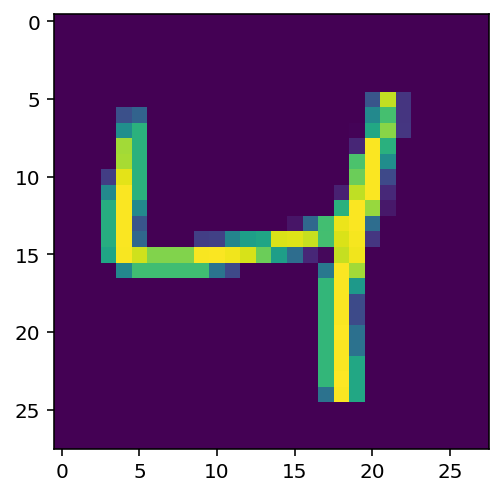

In [8]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to S3.

In [9]:
inputs = sagemaker.Session().upload_data(path="mnist", bucket=bucket, key_prefix=prefix)

Now let's track the parameters from the data pre-processing step.

In [10]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters(
        {
            "normalization_mean": 0.1307,
            "normalization_std": 0.3081,
        }
    )
    # We can log the S3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

## Step 1: Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for: [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [11]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}",
    description="Classification of mnist hand-written digits",
    sagemaker_boto_client=sm,
)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f50bc1de150>,experiment_name='mnist-hand-written-digits-classification-1660168470',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:000000000000:experiment/mnist-hand-written-digits-classification-1660168470',response_metadata={'RequestId': '1ce1ef68-3c15-4971-b77a-4c5f258887b7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '1ce1ef68-3c15-4971-b77a-4c5f258887b7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Wed, 10 Aug 2022 21:54:29 GMT'}, 'RetryAttempts': 0})


## Step 2: Track Experiment
### Now create a Trial for each training run to track its inputs, parameters, and metrics.
While training the CNN model on SageMaker, we experiment with several values for the number of hidden channel in the model. We create a Trial to track each training job run. We also create a TrialComponent from the tracker we created before, and add to the Trial. This enriches the Trial with the parameters we captured from the data pre-processing stage.

In [12]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [13]:
hidden_channel_trial_name_map = {}

If you want to run the following five training jobs in parallel, you may need to increase your resource limit. Here we run them sequentially.

In [14]:
preprocessing_trial_component = tracker.trial_component

In [15]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # Create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name

    # Associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)

    # All input configurations, parameters, and metrics specified in
    # the estimator definition are automatically tracked
    estimator = PyTorch(
        py_version="py3",
        entry_point="./mnist.py",
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version="1.1.0",
        instance_count=1,
        instance_type="ml.c4.xlarge",
        hyperparameters={
            "epochs": 2,
            "backend": "gloo",
            "hidden_channels": num_hidden_channel,
            "dropout": 0.2,
            "kernel_size": 5,
            "optimizer": "sgd",
        },
        metric_definitions=[
            {"Name": "train:loss", "Regex": "Train Loss: (.*?);"},
            {"Name": "test:loss", "Regex": "Test Average loss: (.*?),"},
            {"Name": "test:accuracy", "Regex": "Test Accuracy: (.*?)%;"},
        ],
        enable_sagemaker_metrics=True,
    )

    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))

    # Associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={"training": inputs},
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )

    # Wait two seconds before dispatching the next training job
    time.sleep(2)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1660168481


2022-08-10 21:54:41 Starting - Starting the training job.

.

.


2022-08-10 21:55:08 Starting - Preparing the instances for trainingProfilerReport-1660168481: InProgress
.

.

.

.

.

.

.

.

.


2022-08-10 21:56:25 Downloading - Downloading input data.

.

.

.

.

.

.

.

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-10 21:57:59,050 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-08-10 21:57:59,054 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-08-10 21:57:59,066 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-10 21:57:59,067 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-10 21:57:59,746 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-08-10 21:57:59,746 sagemaker-containers INFO     Generating setup.cfg
2022-08-10 21:57:59,747 sagemaker-containers INFO     Generating MANIFEST.in
2022-08-10 21:57:59,747 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 



2022-08-10 21:58:06 Training - Training image download completed. Training in progress.

Processing /opt/ml/code
  Running setup.py bdist_wheel for mnist: started
  Running setup.py bdist_wheel for mnist: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-el4o4mci/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built mnist
You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2022-08-10 21:58:02,417 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-08-10 21:58:02,432 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_pytorch_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "backend": "gloo",
        "dropout": 0.2,
        "epochs": 2,
      

Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.843992;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.432059;
Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.464780;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.322854;


Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.351526;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.389307;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.375780;
Test Average loss: 0.1852, Test Accuracy: 95%;


Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.275706;
Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.292543;


Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.244455;
Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.283167;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.279576;
Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.341436;
Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.414407;


Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.193495;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.157259;
Test Average loss: 0.1158, Test Accuracy: 97%;
Saving the model.
2022-08-10 21:58:56,590 sagemaker-containers INFO     Reporting training SUCCESS



2022-08-10 21:59:06 Uploading - Uploading generated training model


2022-08-10 21:59:26 Completed - Training job completed
ProfilerReport-1660168481: NoIssuesFound


Training seconds: 173
Billable seconds: 173


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1660168801


2022-08-10 22:00:01 Starting - Starting the training job.

.

.


2022-08-10 22:00:25 Starting - Preparing the instances for trainingProfilerReport-1660168801: InProgress
.

.

.

.

.

.

.

.

.


2022-08-10 22:01:46 Downloading - Downloading input data.

.

.

.

.

.

.

.

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-10 22:03:13,258 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-08-10 22:03:13,262 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-08-10 22:03:13,282 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-10 22:03:13,283 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-10 22:03:13,783 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-08-10 22:03:13,783 sagemaker-containers INFO     Generating setup.cfg
2022-08-10 22:03:13,783 sagemaker-containers INFO     Generating MANIFEST.in
2022-08-10 22:03:13,784 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn


2022-08-10 22:03:26 Training - Training image download completed. Training in progress.Train Epoch: 1 [6400/60000 (11%)], Train Loss: 1.698200;
Train Epoch: 1 [12800/60000 (21%)], Train Loss: 0.994831;
Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.611539;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.648925;


Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.571486;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.791933;
Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.438099;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.549112;


Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.480673;
Test Average loss: 0.1914, Test Accuracy: 94%;
Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.297167;
Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.364907;


Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.268553;
Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.272427;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.382764;
Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.482188;


Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.203590;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.445356;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.197844;
Test Average loss: 0.1157, Test Accuracy: 96%;
Saving the model.
2022-08-10 22:04:10,665 sagemaker-containers INFO     Reporting training SUCCESS



2022-08-10 22:04:31 Uploading - Uploading generated training model
2022-08-10 22:04:31 Completed - Training job completed


Training seconds: 169
Billable seconds: 169


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1660169089


2022-08-10 22:04:49 Starting - Starting the training job.

.

.


2022-08-10 22:05:06 Starting - Preparing the instances for trainingProfilerReport-1660169089: InProgress
.

.

.

.

.

.

.

.

.


2022-08-10 22:06:32 Downloading - Downloading input data.

.

.

.

.

.


2022-08-10 22:07:48 Training - Training image download completed. Training in progress..

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-10 22:07:52,347 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-08-10 22:07:52,351 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-08-10 22:07:52,367 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-10 22:07:52,368 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-10 22:07:52,871 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-08-10 22:07:52,872 sagemaker-containers INFO     Generating setup.cfg
2022-08-10 22:07:52,872 sagemaker-containers INFO     Generating MANIFEST.in
2022-08-10 22:07:52,872 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn

Distributed training - False
Number of gpus available - 0
Get train data loader
Get test data loader
Processes 60000/60000 (100%) of train data
Processes 10000/10000 (100%) of test data
Train Epoch: 1 [6400/60000 (11%)], Train Loss: 1.695285;
Train Epoch: 1 [12800/60000 (21%)], Train Loss: 0.928432;
Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.702160;


Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.442871;
Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.413667;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.501132;
Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.383585;


Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.328490;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.396089;


Test Average loss: 0.1679, Test Accuracy: 95%;
Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.603119;
Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.229334;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.281790;


Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.376957;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.412861;


Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.200810;
Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.233049;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.319483;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.210030;


Test Average loss: 0.1060, Test Accuracy: 97%;
Saving the model.
2022-08-10 22:09:01,629 sagemaker-containers INFO     Reporting training SUCCESS



2022-08-10 22:09:19 Uploading - Uploading generated training model
2022-08-10 22:09:19 Completed - Training job completed


Training seconds: 172
Billable seconds: 172


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1660169377


2022-08-10 22:09:37 Starting - Starting the training job.

.

.


2022-08-10 22:10:02 Starting - Preparing the instances for trainingProfilerReport-1660169377: InProgress
.

.

.

.

.

.

.

.

.


2022-08-10 22:11:22 Downloading - Downloading input data.

.

.

.

.

.

.

.

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-10 22:12:43,815 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-08-10 22:12:43,818 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-08-10 22:12:43,838 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-10 22:12:43,839 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-10 22:12:44,428 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-08-10 22:12:44,429 sagemaker-containers INFO     Generating setup.cfg
2022-08-10 22:12:44,429 sagemaker-containers INFO     Generating MANIFEST.in
2022-08-10 22:12:44,429 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn


2022-08-10 22:13:02 Training - Training image download completed. Training in progress.Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.799500;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.595724;


Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.411506;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.176120;


Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.317887;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.203233;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.264020;


Test Average loss: 0.1407, Test Accuracy: 96%;
Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.384039;


Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.200869;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.399078;
Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.451251;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.263621;


Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.151691;
Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.375438;



2022-08-10 22:14:10 Uploading - Uploading generated training model

Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.332934;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.227200;
Test Average loss: 0.0965, Test Accuracy: 97%;
Saving the model.
2022-08-10 22:14:05,477 sagemaker-containers INFO     Reporting training SUCCESS



2022-08-10 22:14:23 Completed - Training job completed


Training seconds: 182
Billable seconds: 182


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1660169695


2022-08-10 22:14:56 Starting - Starting the training job.

.

.

ProfilerReport-1660169695: InProgress
.

.

.


2022-08-10 22:15:50 Starting - Preparing the instances for training.

.

.

.

.

.


2022-08-10 22:16:50 Downloading - Downloading input data.

.

.

.

.

.


2022-08-10 22:17:50 Training - Training image download completed. Training in progress..

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-10 22:17:50,169 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-08-10 22:17:50,172 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-08-10 22:17:50,189 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-10 22:17:50,191 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-10 22:17:50,553 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-08-10 22:17:50,553 sagemaker-containers INFO     Generating setup.cfg
2022-08-10 22:17:50,553 sagemaker-containers INFO     Generating MANIFEST.in
2022-08-10 22:17:50,554 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn

Train Epoch: 1 [12800/60000 (21%)], Train Loss: 0.827845;
Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.747446;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.516501;


Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.465859;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.380938;


Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.451455;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.202041;


Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.379481;
Test Average loss: 0.1531, Test Accuracy: 95%;
Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.183234;


Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.523121;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.199367;


Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.200822;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.377310;
Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.227790;


Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.642007;


Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.365126;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.101494;


Test Average loss: 0.1012, Test Accuracy: 97%;
Saving the model.
2022-08-10 22:19:25,169 sagemaker-containers INFO     Reporting training SUCCESS



2022-08-10 22:19:51 Uploading - Uploading generated training model
2022-08-10 22:19:51 Completed - Training job completed
ProfilerReport-1660169695: NoIssuesFound


Training seconds: 183
Billable seconds: 183


### Compare the model training runs for an experiment

Now we use the analytics capabilities of the Experiments SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [16]:
search_expression = {
    "Filters": [
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [17]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=["test:accuracy"],
    parameter_names=["hidden_channels", "epochs", "dropout", "optimizer"],
)

In [18]:
trial_component_analytics.dataframe()

TrialComponentName DisplayName  \
0  cnn-training-job-1660169695-aws-training-job    Training   
1  cnn-training-job-1660168481-aws-training-job    Training   
2  cnn-training-job-1660169089-aws-training-job    Training   
3  cnn-training-job-1660169377-aws-training-job    Training   
4  cnn-training-job-1660168801-aws-training-job    Training   

                                           SourceArn  dropout  epochs  \
0  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
1  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
2  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
3  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
4  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   

   hidden_channels optimizer  test:accuracy - Min  test:accuracy - Max  \
0             32.0     "sgd"                 95.0                 97.0   
1              2.0     "sgd"                 95.0                 97.0   
2             10.0     "sgd"                 95.0                 97.0   
3             20.0     "sgd"                 96.0                 97.0   
4              5.0     "sgd"                 94.0                 96.0   

   test:accuracy - Avg  ...  test:accuracy - Last  test:accuracy - Count  \
0                 96.0  ...                  97.0                      2   
1                 96.0  ...                  97.0                      2   
2                 96.0  ...                  97.0                      2   
3                 96.5  ...                  97.0                      2   
4                 95.0  ...                  96.0                      2   

   training - MediaType                                  training - Value  \
0                  None  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   
1                  None  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   
2                  None  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   
3                  None  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   
4                  None  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   

  SageMaker.DebugHookOutput - MediaType  \
0                                  None   
1                                  None   
2                                  None   
3                                  None   
4                                  None   

        SageMaker.DebugHookOutput - Value SageMaker.ModelArtifact - MediaType  \
0  s3://sagemaker-us-west-2-000000000000/                                None   
1  s3://sagemaker-us-west-2-000000000000/                                None   
2  s3://sagemaker-us-west-2-000000000000/                                None   
3  s3://sagemaker-us-west-2-000000000000/                                None   
4  s3://sagemaker-us-west-2-000000000000/                                None   

                     SageMaker.ModelArtifact - Value  \
0  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
1  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
2  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
3  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
4  s3://sagemaker-us-west-2-000000000000/cnn-trai...   

                                             Trials  \
0  [cnn-training-job-32-hidden-channels-1660169695]   
1   [cnn-training-job-2-hidden-channels-1660168480]   
2  [cnn-training-job-10-hidden-channels-1660169089]   
3  [cnn-training-job-20-hidden-channels-1660169377]   
4   [cnn-training-job-5-hidden-channels-1660168800]   

                                         Experiments  
0  [mnist-hand-written-digits-classification-1660...  
1  [mnist-hand-written-digits-classification-1660...  
2  [mnist-hand-written-digits-classification-1660...  
3  [mnist-hand-written-digits-classification-1660...  
4  [mnist-hand-written-digits-classification-1660...  

[5 rows x 21 columns]

To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for the `cnn-training-job-2-hidden-channels` trial.

In [19]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    search_expression={
        "Filters": [
            {
                "Name": "Parents.TrialName",
                "Operator": "Equals",
                "Value": hidden_channel_trial_name_map[2],
            }
        ]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [20]:
lineage_table.dataframe()

TrialComponentName    DisplayName  \
0         TrialComponent-2022-08-10-215425-svma  Preprocessing   
1  cnn-training-job-1660168481-aws-training-job       Training   

   normalization_mean  normalization_std mnist-dataset - MediaType  \
0              0.1307             0.3081                    s3/uri   
1                 NaN                NaN                       NaN   

                              mnist-dataset - Value  \
0  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   
1                                               NaN   

                                              Trials  \
0  [cnn-training-job-10-hidden-channels-166016908...   
1    [cnn-training-job-2-hidden-channels-1660168480]   

                                         Experiments  \
0  [mnist-hand-written-digits-classification-1660...   
1  [mnist-hand-written-digits-classification-1660...   

                                           SourceArn  \
0                                                NaN   
1  arn:aws:sagemaker:us-west-2:000000000000:train...   

                                  SageMaker.ImageUri  ...  train:loss - Avg  \
0                                                NaN  ...               NaN   
1  520713654638.dkr.ecr.us-west-2.amazonaws.com/s...  ...          0.456703   

  train:loss - StdDev  train:loss - Last train:loss - Count  \
0                 NaN                NaN                NaN   
1            0.352488           0.157259               18.0   

   training - MediaType                                  training - Value  \
0                   NaN                                               NaN   
1                   NaN  s3://sagemaker-us-west-2-000000000000/DEMO-mnist   

   SageMaker.DebugHookOutput - MediaType  \
0                                    NaN   
1                                    NaN   

        SageMaker.DebugHookOutput - Value SageMaker.ModelArtifact - MediaType  \
0                                     NaN                                 NaN   
1  s3://sagemaker-us-west-2-000000000000/                                 NaN   

                     SageMaker.ModelArtifact - Value  
0                                                NaN  
1  s3://sagemaker-us-west-2-000000000000/cnn-trai...  

[2 rows x 48 columns]

## Push best training job model to model registry
Now we take the best model and push it to [model registry](#https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).

### Step 1: Create a model package group.

In [21]:
import time

model_package_group_name = "mnist-handwritten-digit-claissification" + str(round(time.time()))
model_package_group_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageGroupDescription": "Sample model package group",
}

create_model_package_group_response = sm.create_model_package_group(
    **model_package_group_input_dict
)
model_package_arn = create_model_package_group_response["ModelPackageGroupArn"]

print(f"ModelPackageGroup Arn : {model_package_arn}")

ModelPackageGroup Arn : arn:aws:sagemaker:us-west-2:000000000000:model-package-group/mnist-handwritten-digit-claissification1660170021


In [22]:
model_package_arn

'arn:aws:sagemaker:us-west-2:000000000000:model-package-group/mnist-handwritten-digit-claissification1660170021'

### Step 2: Get the best model training job from SageMaker experiments API

In [23]:
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]["TrialComponentName"]
best_trial_component = TrialComponent.load(best_trial_component_name)

In [24]:
best_trial_component.trial_component_name

'cnn-training-job-1660169695-aws-training-job'

### Step 3: Register the best model.
By default, the model is registered with the `approval_status` set to `PendingManualApproval`. Users can then use API to manually approve the model based on any criteria set for model evaluation.

In [25]:
# create model object
model_data = best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value
env = {
    "hidden_channels": str(int(best_trial_component.parameters["hidden_channels"])),
    "dropout": str(best_trial_component.parameters["dropout"]),
    "kernel_size": str(int(best_trial_component.parameters["kernel_size"])),
}
model = PyTorchModel(
    model_data,
    role,
    "./mnist.py",
    py_version="py3",
    env=env,
    sagemaker_session=sagemaker.Session(sagemaker_client=sm),
    framework_version="1.1.0",
    name=best_trial_component.trial_component_name,
)

In [26]:
model_package = model.register(
    content_types=["*"],
    response_types=["application/json"],
    inference_instances=["ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    description="MNIST image classification model",
    approval_status="PendingManualApproval",
    model_package_group_name=model_package_group_name,
)

### Step 4: Verify model has been registered.

In [27]:
sm.describe_model_package_group(ModelPackageGroupName=model_package_group_name)

{'ModelPackageGroupName': 'mnist-handwritten-digit-claissification1660170021',
 'ModelPackageGroupArn': 'arn:aws:sagemaker:us-west-2:000000000000:model-package-group/mnist-handwritten-digit-claissification1660170021',
 'ModelPackageGroupDescription': 'Sample model package group',
 'CreationTime': datetime.datetime(2022, 8, 10, 22, 20, 20, 649000, tzinfo=tzlocal()),
 'ModelPackageGroupStatus': 'Completed',
 'ResponseMetadata': {'RequestId': '7005f604-0505-40f5-ba87-702f25c9a5fe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7005f604-0505-40f5-ba87-702f25c9a5fe',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '343',
   'date': 'Wed, 10 Aug 2022 22:20:27 GMT'},
  'RetryAttempts': 0}}

In [28]:
## check model version
sm.list_model_packages(ModelPackageGroupName=model_package_group_name)

{'ModelPackageSummaryList': [{'ModelPackageGroupName': 'mnist-handwritten-digit-claissification1660170021',
   'ModelPackageVersion': 1,
   'ModelPackageArn': 'arn:aws:sagemaker:us-west-2:000000000000:model-package/mnist-handwritten-digit-claissification1660170021/1',
   'ModelPackageDescription': 'MNIST image classification model',
   'CreationTime': datetime.datetime(2022, 8, 10, 22, 20, 25, 942000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'PendingManualApproval'}],
 'ResponseMetadata': {'RequestId': '863ac307-c8c6-4251-a4fb-8200309913f6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '863ac307-c8c6-4251-a4fb-8200309913f6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '430',
   'date': 'Wed, 10 Aug 2022 22:20:28 GMT'},
  'RetryAttempts': 0}}

In [29]:
model_package_arn = sm.list_model_packages(ModelPackageGroupName=model_package_group_name)[
    "ModelPackageSummaryList"
][0]["ModelPackageArn"]

In [30]:
### Update the model status to approved
model_package_update_input_dict = {
    "ModelPackageArn": model_package_arn,
    "ModelApprovalStatus": "Approved",
}
model_package_update_response = sm.update_model_package(**model_package_update_input_dict)

## Deploy an endpoint for the lastest approved version of the model from model registry

Now we take the best model and deploy it to an endpoint so it is available to perform inference.

In [31]:
from datetime import datetime

now = datetime.now()
time = now.strftime("%m-%d-%Y-%H-%M-%S")
print("time:", time)
endpoint_name = f"cnn-mnist-{time}"
endpoint_name

time: 08-10-2022-22-20-30


'cnn-mnist-08-10-2022-22-20-30'

In [32]:
model_package.deploy(
    initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=endpoint_name
)

INFO:sagemaker:Creating model with name: 1-2022-08-10-22-20-31-635


INFO:sagemaker:Creating endpoint-config with name cnn-mnist-08-10-2022-22-20-30


INFO:sagemaker:Creating endpoint with name cnn-mnist-08-10-2022-22-20-30


-

-

-

-

!

## Cleanup

Once we're done, clean up the endpoint to prevent unnecessary billing.

In [33]:
sagemaker_client = boto3.client("sagemaker", region_name=region)
# Delete endpoint
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '1c522170-66e3-4c3d-8b95-e2a16880ad2d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '1c522170-66e3-4c3d-8b95-e2a16880ad2d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 10 Aug 2022 22:22:33 GMT'},
  'RetryAttempts': 0}}

In [34]:
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_name)

{'ResponseMetadata': {'RequestId': '9b9c4a53-70f8-4804-9913-e0d464249e29',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9b9c4a53-70f8-4804-9913-e0d464249e29',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 10 Aug 2022 22:22:34 GMT'},
  'RetryAttempts': 0}}

Trial components can exist independently of trials and experiments. You might want keep them if you plan on further exploration. If not, delete all experiment artifacts.

In [35]:
mnist_experiment.delete_all(action="--force")

## Contact
Submit any questions or issues to https://github.com/aws/sagemaker-experiments/issues or mention @aws/sagemakerexperimentsadmin 